# Predicting risk factors for maternal mortality
by Apoorva Srivastava, Guaner (Gloria) Yi, Jeffrey Ding & Randall Lee 2025/11/22

In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer, recall_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_auc_score

# Summary
Fill in with summary...

# Introduction
Fill in with introduction...

# Methods

## Data
The data set used in this project is of health conditions of pregnant women from the rural areas of Bangladesh created by Marzia Ahmed at Daffodil International University. This dataset was sourced from the UC Irvine Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/dataset/863/maternal+health+risk). Each observation in the dataset corresponds to a pregnant individual's health profile, comprising a risk intensity level (low, medium, or high risk) and associated clinical measurements including demographic information (age) and vital signs (systolic blood pressure, diastolic blood pressure, blood glucose concentration, body temperature, and resting heart rate). The data set was collected via an IoT-based risk monitoring system from hospitals, community clinics, and maternal health cares in rural Bangladesh.

### Data dictionary
| Column Name | Role    | Type        | Description |
|-------------|---------|-------------|-------------|
| Age         | Feature | Integer     | Age of the patient during pregnancy (in years) |
| SystolicBP  | Feature | Integer     | Systolic (upper) blood pressure measured in mmHg |
| DiastolicBP | Feature | Integer     | Diastolic (lower) blood pressure measured in mmHg |
| BS          | Feature | Integer     | Blood sugar level measured in mmol/L |
| BodyTemp    | Feature | Integer     | Body temperature of the patient measured in °F |
| HeartRate   | Feature | Integer     | Patient's resting heart rate measured in bpm |
| RiskLevel   | Target  | Categorical | Predicted pregnancy risk level based on clinical features |

## Analysis
Fill in with analysis...
- SVC (Support Vector Classification) algorithm used

## Results & Discussion
Fill in with Results & Discussion...

In [2]:
# download data as zip and extract
url = "https://archive.ics.uci.edu/static/public/863/maternal+health+risk.zip"

request = requests.get(url)
with open("../data/raw/maternal+health+risk.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("../data/raw/maternal+health+risk.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/raw")

In [3]:
health_data = pd.read_csv("../data/raw/Maternal Health Risk Data Set.csv", header=0)
health_data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [4]:
health_data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [5]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [6]:
train_df, test_df = train_test_split(
    health_data, test_size=0.3, random_state=123
)
X_train, y_train = train_df.drop(columns=['RiskLevel']), train_df["RiskLevel"]
X_test, y_test = test_df.drop(columns=['RiskLevel']), test_df["RiskLevel"]

train_df.to_csv("../data/processed/maternal_health_risk_train.csv")
test_df.to_csv("../data/processed/maternal_health_risk_test.csv")

In [7]:
train_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1003,50,130,100,16.0,98.0,76,high risk
243,32,120,65,6.0,101.0,76,mid risk
848,15,70,50,6.0,98.0,70,mid risk
202,23,90,60,7.5,98.0,76,low risk
300,15,75,49,7.7,98.0,77,low risk
...,...,...,...,...,...,...,...
988,25,120,90,12.0,101.0,80,high risk
322,65,90,60,6.9,98.0,70,low risk
382,17,90,65,7.8,103.0,67,high risk
365,22,120,90,7.8,98.0,82,mid risk


In [8]:
test_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
50,25,120,80,7.0,98.0,66,low risk
784,35,100,70,6.8,98.0,60,mid risk
204,15,76,49,7.5,98.0,77,low risk
85,18,90,60,6.9,98.0,70,mid risk
802,42,130,80,18.0,98.0,70,mid risk
...,...,...,...,...,...,...,...
619,29,130,70,7.5,98.0,78,mid risk
607,45,120,95,7.5,98.0,66,low risk
700,15,120,80,6.6,99.0,70,low risk
1005,17,90,65,7.7,103.0,67,high risk


In [9]:
y_train.value_counts()

RiskLevel
low risk     286
mid risk     238
high risk    185
Name: count, dtype: int64

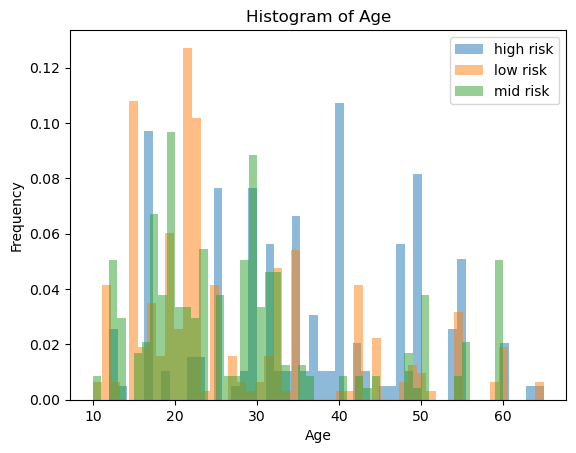

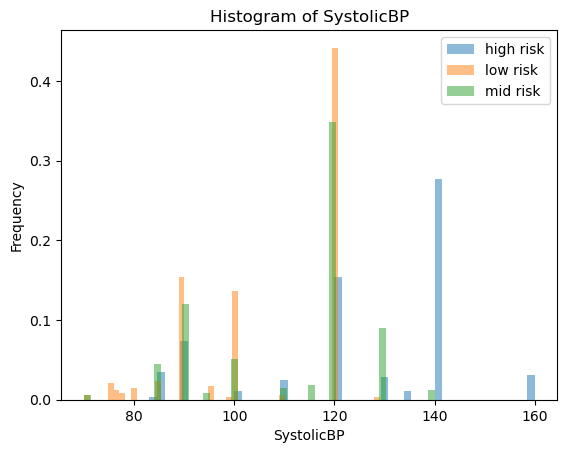

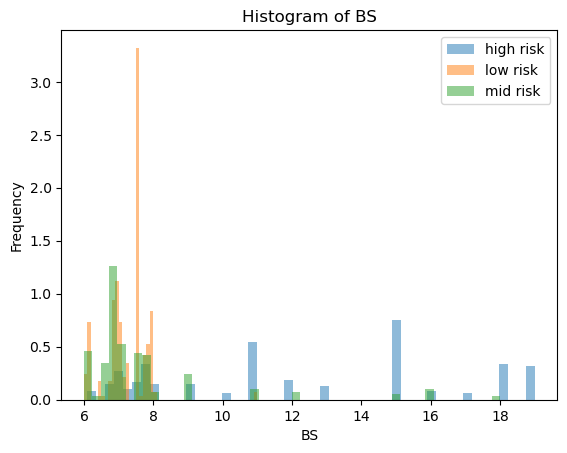

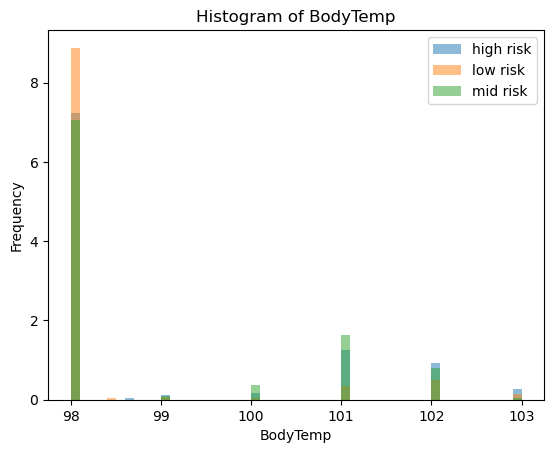

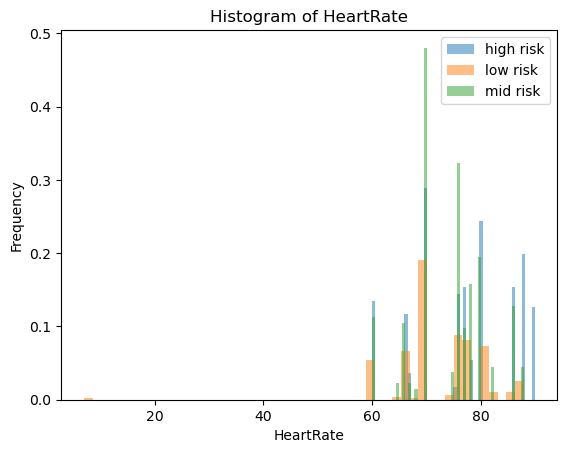

In [10]:
feature_cols = ["Age", "SystolicBP", "BS", "BodyTemp", "HeartRate"]

for feature in feature_cols:
    train_df.groupby("RiskLevel")[feature].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feature);
    plt.xlabel(feature);
    plt.show()

Figure 1. Comparison of the distributions of features contributing to the risk intensity level during pregnancy of an individual.

We selected a Support Vector Classifier (SVC) model for this classification task. To identify the model configuration that best predicted maternal health risk levels, we performed hyperparameter tuning using randomized search with 10-fold cross-validation and recall score (weighted) as our evaluation metric to select the optimal values for C (regularization parameter), gamma (kernel coefficient). We found that the optimal hyperparameters were 760 for C and 5.8 for gamma.

In [11]:
preprocessor = make_column_transformer(
    (StandardScaler(), feature_cols)
)

In [12]:
preprocessor.fit(X_train)

,transformers,"[('standardscaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [13]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), 
    index=X_train.index, 
    columns=preprocessor.get_feature_names_out()
)  

# Show the transformed data
X_train_enc

,standardscaler__Age,standardscaler__SystolicBP,standardscaler__BS,standardscaler__BodyTemp,standardscaler__HeartRate
1003,1.539667,0.915275,2.278454,-0.499908,0.209123
243,0.182676,0.373190,-0.820502,1.630962,0.209123
848,-1.098927,-2.337235,-0.820502,-0.499908,-0.543507
202,-0.495820,-1.253065,-0.355659,-0.499908,0.209123
300,-1.098927,-2.066193,-0.293680,-0.499908,0.334561
...,...,...,...,...,...
988,-0.345043,0.373190,1.038872,1.630962,0.710876
322,2.670493,-1.253065,-0.541596,-0.499908,-0.543507
382,-0.948150,-1.253065,-0.262690,3.051541,-0.919822
365,-0.571208,0.373190,-0.262690,-0.499908,0.961753


In [14]:
dc = DummyClassifier()

In [15]:
dc_score = pd.DataFrame(cross_validate(dc, X_train, y_train, cv=5, return_train_score=True))

In [16]:
dc_score

,fit_time,score_time,test_score,train_score
0,0.000710,0.000667,0.401408,0.403880
1,0.000492,0.000317,0.401408,0.403880
2,0.000311,0.000259,0.401408,0.403880
3,0.000298,0.000253,0.408451,0.402116
4,0.000301,0.000246,0.404255,0.403169


In [17]:
svc = make_pipeline(preprocessor, SVC())

In [18]:
svc_score = pd.DataFrame(cross_validate(svc, X_train, y_train, cv=5, return_train_score=True))

In [19]:
svc_score

,fit_time,score_time,test_score,train_score
0,0.008482,0.003989,0.725352,0.707231
1,0.006610,0.003479,0.676056,0.719577
2,0.006857,0.003537,0.718310,0.719577
3,0.006519,0.003372,0.711268,0.708995
4,0.006170,0.003316,0.659574,0.727113


- Use recall score as the evaluation metric because it measures the percentage of actual high-risk 
- pregnancies correctly identified. This is critical for maternal health where missing high-risk cases 
- (false negatives) could be dangerous. Recall prioritizes catching all high-risk cases, even if it 
- means more false alarms, which is acceptable since extra monitoring is safer than missed risks.


In [20]:
svc_score = pd.DataFrame(cross_validate(svc, X_train, y_train, cv=5, return_train_score=True, scoring="recall_weighted"))

In [21]:
svc_score

,fit_time,score_time,test_score,train_score
0,0.006944,0.004370,0.725352,0.707231
1,0.006584,0.004295,0.676056,0.719577
2,0.006746,0.004328,0.718310,0.719577
3,0.006527,0.004187,0.711268,0.708995
4,0.006218,0.004171,0.659574,0.727113


In [22]:
param_grid = {
    "svc__C": loguniform(1e-2, 1e3),
    "svc__gamma": loguniform(1e-4, 1e1)
}

In [23]:
random_search = RandomizedSearchCV(svc,                                    
                  param_distributions=param_grid, 
                  n_iter=100, 
                  n_jobs=-1,
                  return_train_score=True,
                  cv=10,
                  scoring='recall_weighted',
                  random_state=123)

random_search.fit(X_train, y_train)

,estimator,"Pipeline(step...svc', SVC())])"
,param_distributions,"{'svc__C': <scipy.stats....t 0x18496e270>, 'svc__gamma': <scipy.stats....t 0x184993860>}"
,n_iter,100
,scoring,'recall_weighted'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [24]:
random_search.best_score_

np.float64(0.7615895372233401)

In [25]:
result_grid = pd.DataFrame(random_search.cv_results_)
result_grid = result_grid[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T.iloc[:, :10]

result_grid

rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,0.761590,0.760221,0.755956,0.753159,0.751771,0.734849,0.733400,0.730624,0.729215,0.720644
param_svc__gamma,1.615660,8.282366,1.280916,2.749691,9.479652,1.571147,8.468353,2.134628,1.766684,0.265551
param_svc__C,422.340226,323.263643,198.127782,21.103877,33.480671,34.953203,2.601185,10.080750,14.859520,801.347695
mean_fit_time,0.022902,0.020011,0.017393,0.017701,0.020673,0.017542,0.015783,0.015643,0.014630,0.054393


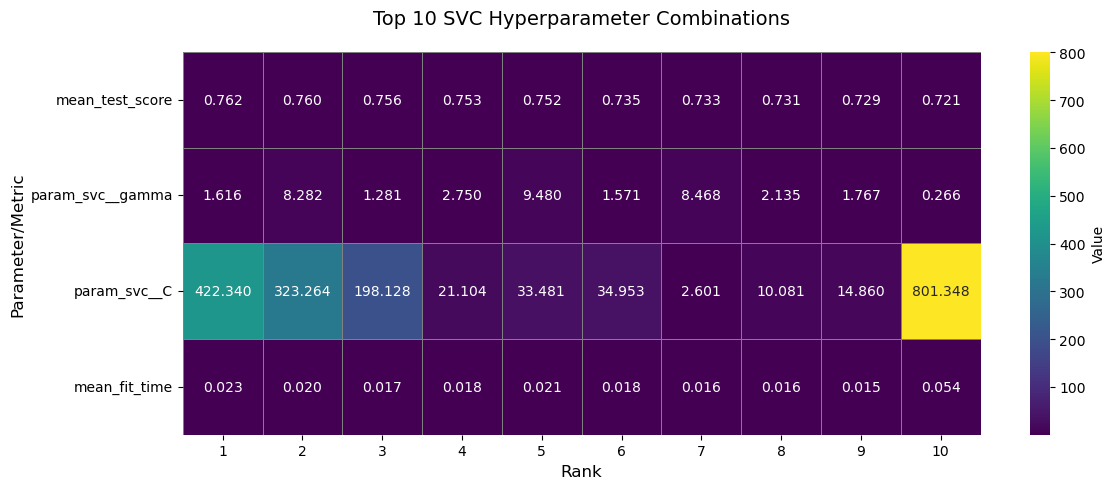

In [26]:
plt.figure(figsize=(12, 5))
sns.heatmap(result_grid, 
            annot=True,           
            fmt='.3f',           
            cmap='viridis',        
            cbar_kws={'label': 'Value'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Top 10 SVC Hyperparameter Combinations', fontsize=14, pad=20)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Parameter/Metric', fontsize=12)
plt.tight_layout()
plt.show()

Figure 2. Results from hyperparameter optimization and 10-fold cross validation to choose gamma and C. Recall score was used as the classification metric as gamma and C was varied.

In [27]:
accuracy_score = random_search.score(
    X_test, y_test
)

In [28]:
accuracy_score

0.7836065573770492

In [29]:
maternal_preds = X_test.assign(
    predicted=random_search.best_estimator_.predict(X_test)
)

# Add the actual labels
maternal_preds['actual'] = y_test.values

# Compute recall score (weighted for multi-class)
recall = recall_score(
    maternal_preds['actual'],
    maternal_preds['predicted'],
    average='weighted'
)

In [30]:
recall

0.7836065573770492

In [31]:
pd.crosstab(
    maternal_preds["actual"],
    maternal_preds["predicted"],
)

predicted,high risk,low risk,mid risk
actual,,,
high risk,74,2,11
low risk,4,95,21
mid risk,9,19,70


Text(0.5, 1.0, 'Confusion Matrix - Test Data')

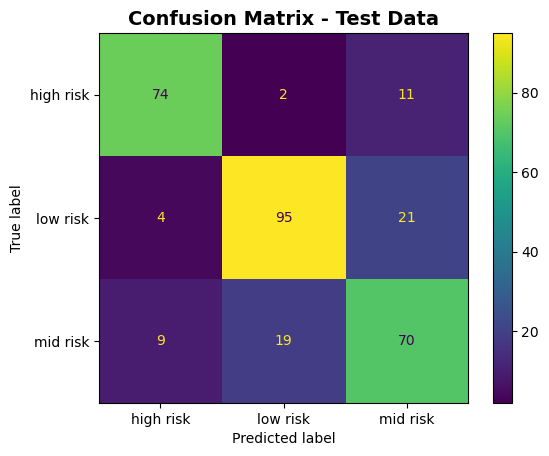

In [32]:
confmat_logreg_bal = ConfusionMatrixDisplay.from_predictions(
    y_test,
    random_search.best_estimator_.predict(X_test),
    #normalize='all'
)
confmat_logreg_bal.ax_.set_title('Confusion Matrix - Test Data', fontsize=14, fontweight='bold')

Figure 3. Confusion matrix of model performance on test data.

high risk: AUC = 0.953
low risk: AUC = 0.884
mid risk: AUC = 0.858


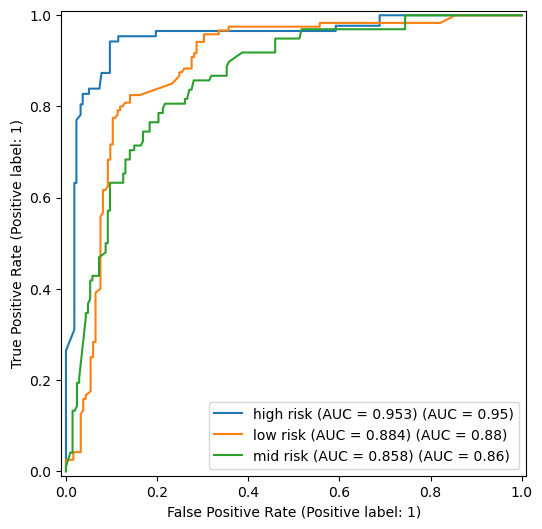

In [33]:
y_score = random_search.best_estimator_.decision_function(X_test)
svc_classes = random_search.best_estimator_.named_steps['svc'].classes_
y_test_bin = label_binarize(y_test, classes=svc_classes)
fig, ax = plt.subplots(figsize=(6, 8))

for i, class_name in enumerate(svc_classes):
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f'{class_name} (AUC = {auc:.3f})',
        ax=ax
    )
    print(f"{class_name}: AUC = {auc:.3f}")

Figure 4. ROC curve of model performance on test data.

## Summary of model results
Fill in with summary of results...

## References

Fill in with references...